In [1]:
# import standard libraries
import glob
import os
import re
# import third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlf import read_patent_file, TICK_NAME

In [2]:
filepaths = glob.glob('data/patents/raw/*.gz')
data = [read_patent_file(f) for f in filepaths]

In [3]:
# read all dataframes in one big dataframe
data_all = pd.concat(data, axis=0)

# Exploratory data analysis

In [4]:
data_all.dropna(how='all', inplace=True, axis=1)

In [5]:
numeric_col = ['cited_patent_number', 'citedby_patent_number', 'num_inventor',
              'patent_num_claims', 'patent_processing_time']
date_col = ['app_date', 'patent_date']

In [6]:
# change type of certain columns
data_all[numeric_col] = data_all[numeric_col].astype(np.float64)

In [7]:
for col in date_col:
    data_all[col] = pd.to_datetime(data_all[col], format='%Y-%m-%d')

In [8]:
data_all.shape

(11098, 20)

In [9]:
data_all.columns

Index(['app_date', 'app_number', 'assignee_organization',
       'cited_patent_number', 'citedby_patent_number', 'cpc_group_title',
       'cpc_subgroup_title', 'cpc_subsection_title', 'num_inventor',
       'nber_subcategory_title', 'patent_abstract', 'patent_date',
       'patent_num_claims', 'patent_number', 'patent_processing_time',
       'patent_title', 'uspc_mainclass_title', 'uspc_subclass_title',
       'wipo_field_title', 'wipo_sector_title'],
      dtype='object')

In [10]:
data_missing = data_all.isna().sum()
data_missing = data_missing[data_missing > 0]
pd.DataFrame(data = data_missing, columns=['#nan'])

,#nan
cpc_group_title,532
cpc_subgroup_title,532
cpc_subsection_title,532
nber_subcategory_title,7742
patent_abstract,360
uspc_mainclass_title,3319
uspc_subclass_title,7548
wipo_field_title,534
wipo_sector_title,534


Most features that have nan values are actually text cells, all the rest seems good. Let's concantenate all text info together for some NLP

<AxesSubplot:xlabel='citedby_patent_number', ylabel='Count'>

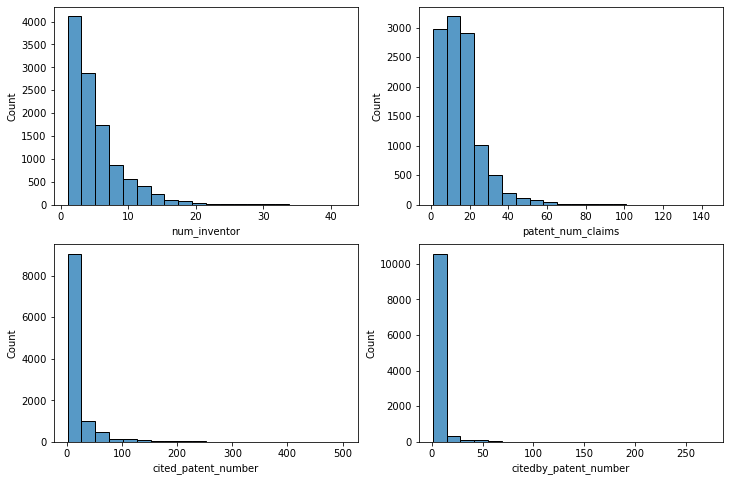

In [11]:
fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
sns.histplot(data_all['num_inventor'], bins=20, ax=ax[0, 0])
sns.histplot(data_all['patent_num_claims'], bins=20, ax=ax[0, 1])
sns.histplot(data_all['cited_patent_number'], bins=20, ax=ax[1, 0])
sns.histplot(data_all['citedby_patent_number'], bins=20, ax=ax[1, 1])

In [12]:
# look at dates
data_all[date_col].describe()

<ipython-input-12-31a29b158b8c>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_all[date_col].describe()
<ipython-input-12-31a29b158b8c>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data_all[date_col].describe()


,app_date,patent_date
count,11098,11098
unique,2325,506
top,2013-03-15 00:00:00,2017-05-23 00:00:00
freq,49,45
first,2010-01-04 00:00:00,2010-08-31 00:00:00
last,2019-12-20 00:00:00,2020-09-29 00:00:00


In [13]:
wipo_sector = data_all[['patent_date', 'wipo_sector_title']]
wipo_sector = wipo_sector.sort_values('patent_date')
wipo_sector['year'] = wipo_sector['patent_date'].apply(lambda x: x.year)
wipo_sector = wipo_sector.drop(columns='patent_date').reset_index(drop=True)
wipo_sector = wipo_sector.dropna(how='any')
wipo_sector['wipo_sector_title'] = wipo_sector['wipo_sector_title'].str.split(' ')
wipo_sector['wipo_sector_title'] = wipo_sector['wipo_sector_title'].apply(lambda x: list(set(x)))
wipo_sector = wipo_sector.explode('wipo_sector_title')
wipo_sector = wipo_sector[(wipo_sector['year'] < 2020) & (wipo_sector['year'] > 2011)]

<AxesSubplot:xlabel='year', ylabel='count'>

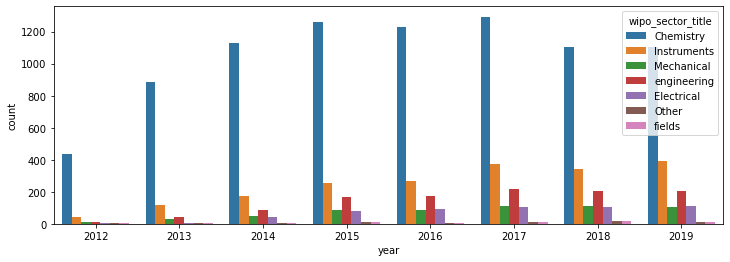

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(x='year', data=wipo_sector, hue='wipo_sector_title', ax=ax)

In [15]:
wipo_field = data_all[['patent_date', 'wipo_field_title']]
wipo_field = wipo_field.sort_values('patent_date')
wipo_field['year'] = wipo_field['patent_date'].apply(lambda x: x.year)
wipo_field = wipo_field.drop(columns='patent_date').reset_index(drop=True)
wipo_field = wipo_field.dropna(how='any')
wipo_field['wipo_field_title'] = wipo_field['wipo_field_title'].apply(lambda x: re.findall('[A-Z][^A-Z]*', x))
wipo_field['wipo_field_title'] = wipo_field['wipo_field_title'].apply(lambda x: list(set(x)))
wipo_field = wipo_field.explode('wipo_field_title')
wipo_field['wipo_field_title'] = wipo_field['wipo_field_title'].str.strip()
wipo_field = wipo_field[(wipo_field['year'] < 2020) & (wipo_field['year'] > 2011)]

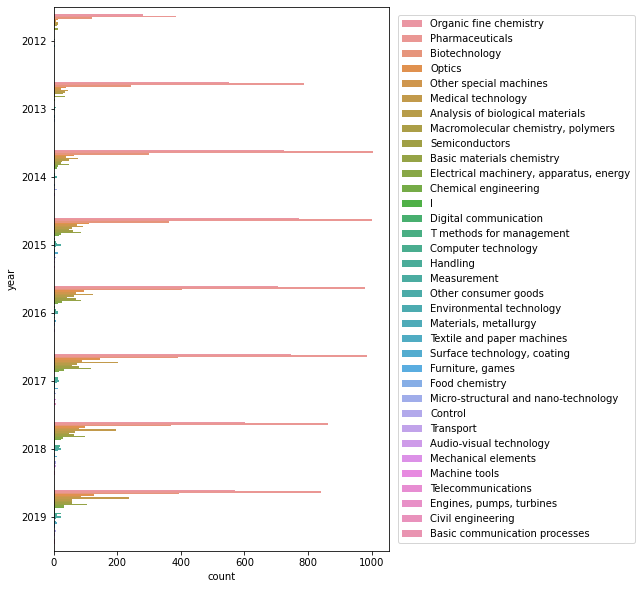

In [16]:
fig, ax = plt.subplots(figsize=(6, 10))
ax = sns.countplot(y='year', data=wipo_field, hue='wipo_field_title', ax=ax)
ax.legend(loc='right', bbox_to_anchor=(1.75, 0.5), ncol=1)